In [1]:
%env JAX_ENABLE_X64 True

env: JAX_ENABLE_X64=True


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as mvn

from stein_thinning.thinning import thin

from utils.caching import make_cached_s3
from utils.paths import S3_BUCKET_NAME

In [3]:
cached = make_cached_s3(S3_BUCKET_NAME)

### Generate a random sample from a bivariate Gaussian

In [4]:
rng = np.random.default_rng(12345)

In [5]:
mean = np.array([0., 0.])
cov = np.array([
    [1., 0.8],
    [0.8, 1.],
])

In [6]:
n_max = 5_000_000
n = 100_000

In [7]:
sample = mvn.rvs(mean=mean, cov=cov, size=n_max, random_state=rng)
grad = (np.linalg.inv(cov) @ (mean - sample).T).T

### Apply standard Stein thinning

In [8]:
m = 100

In [9]:
idx = thin(sample[:n], grad[:n], m)

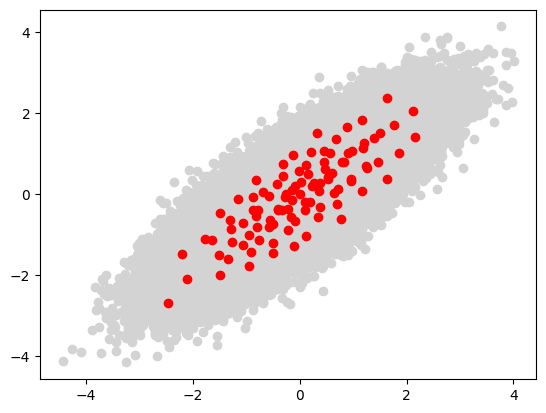

In [10]:
fig, ax = plt.subplots();
ax.scatter(sample[:n, 0], sample[:n, 1], color='lightgray');
ax.scatter(sample[idx, 0], sample[idx, 1], color='red');

Time the standard Stein thinning implementation

In [11]:
%%timeit
thin(sample[:n], grad[:n], m)

1.57 s ± 97.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Replicate the result of standard Stein thinning using a custom kernel

In [12]:
from stein_thinning.kernel import make_imq
from stein_thinning.thinning import _greedy_search, _validate_and_standardize

In [13]:
s, g = _validate_and_standardize(sample[:n], grad[:n], True)
vfk0 = make_imq(s, 'id')

In [14]:
def integrand(ind1, ind2):
    return vfk0(s[ind1], s[ind2], g[ind1], g[ind2])

In [15]:
idx2 = _greedy_search(m, integrand)

In [16]:
np.testing.assert_array_equal(idx2, idx)

In [17]:
%%timeit
_greedy_search(m, integrand)

1.53 s ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Check the impact of logging

In [18]:
def _greedy_search_no_log(n_points, integrand):
    # Pre-allocate the index array
    idx = np.empty(n_points, dtype=np.uint32)

    # Array for the running sums
    k0 = integrand(slice(None), slice(None))

    idx[0] = np.argmin(k0)
    #logger.debug('THIN: %d of %d', 1, n_points)
    for i in range(1, n_points):
        k0 += 2 * integrand(slice(None), [idx[i - 1]])
        idx[i] = np.argmin(k0)
        #logger.debug('THIN: %d of %d', i + 1, n_points)

    return idx

In [19]:
%%timeit
_greedy_search_no_log(m, integrand)

1.44 s ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Create a JAX-based kernel

In [20]:
import jax
import jax.numpy as jnp

In [21]:
from stein_thinning.kernel import make_precon

In [22]:
@jax.jit
def vfk0_imq(x, y, sx, sy, linv, c=1.0, beta=-0.5):
    xmy = x.T - y.T
    qf = c + jnp.sum(jnp.dot(linv, xmy) * xmy, axis=0)
    t1 = -4 * beta * (beta - 1) * jnp.sum(jnp.dot(jnp.dot(linv, linv), xmy) * xmy, axis=0) / (qf ** (-beta + 2))
    t2 = -2 * beta * (jnp.trace(linv) + jnp.sum(jnp.dot(linv, sx.T - sy.T) * xmy, axis=0)) / (qf ** (-beta + 1))
    t3 = jnp.sum(sx.T * sy.T, axis=0) / (qf ** (-beta))
    return t1 + t2 + t3

In [23]:
preconditioner = make_precon(s, 'id')

In [24]:
def vfk0_jax(sample1, sample2, gradient1, gradient2):
    return vfk0_imq(jnp.array(sample1), jnp.array(sample2), jnp.array(gradient1), jnp.array(gradient2), jnp.array(preconditioner))

In [25]:
def integrand_jax(ind1, ind2):
    return vfk0_jax(s[ind1], s[ind2], g[ind1], g[ind2])

In [26]:
idx3 = _greedy_search(m, integrand_jax)

Ensure that the resulting indices remain the same:

In [27]:
np.testing.assert_array_equal(idx3, idx)

Time the JAX-based version:

In [28]:
%%timeit
_greedy_search(m, integrand_jax)

1.16 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Create a JAX-based greedy algorithm

In [29]:
from jax.lax import scan

In [30]:
def greedy_search_jax(n, m):
    s, g = _validate_and_standardize(sample[:n], grad[:n], True)
    s_jax = jnp.array(s)
    g_jax = jnp.array(g)
    preconditioner_jax = jnp.array(preconditioner)

    k0 = vfk0_imq(s_jax, s_jax, g_jax, g_jax, preconditioner_jax)
    idx0 = jnp.argmin(k0)
    def body_fun(val, i):
        prev_idx = val[0]
        k0 = val[1] + 2 * vfk0_imq(s_jax, s_jax[prev_idx].reshape(1, -1), g_jax, g_jax[prev_idx].reshape(1, -1), preconditioner_jax)
        selected_idx = jnp.argmin(k0)
        return (selected_idx, k0), selected_idx
    _, idx  = scan(body_fun, (idx0, k0), jnp.arange(1, m))
    return np.concatenate([[idx0], idx])

In [31]:
idx4 = greedy_search_jax(n, m)

In [32]:
np.testing.assert_array_equal(idx4, idx)

Time this version:

In [33]:
%%timeit
greedy_search_jax(n, m)

1.09 s ± 127 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Plot the speedup from using JAX

In [34]:
import timeit

In [35]:
def calculate_avg_time(func, n_repeats=10):
    return timeit.timeit(func, number=n_repeats) / n_repeats

In [36]:
def calculate_avg_time_numpy(n, m, n_repeats=10):
    print(f'Calculating numpy time for n={n}, m={m}')
    return calculate_avg_time(lambda: thin(sample[:n], grad[:n], m), n_repeats=n_repeats)

In [37]:
def calculate_avg_time_jax(n, m, n_repeats=10):
    print(f'Calculating JAX time for n={n}, m={m}')
    return calculate_avg_time(lambda: greedy_search_jax(n, m), n_repeats=n_repeats)

In [38]:
ns = np.array([100, 500, 1000, 5000, 10_000, 50_000, 100_000, 500_000, 1_000_000, 5_000_000])

In [39]:
@cached()
def thinning_jax_speedup_m_fixed_aws(m) -> pd.DataFrame:
    return pd.DataFrame({
        'Numpy': np.fromiter((calculate_avg_time_numpy(ns[i], m) for i in range(len(ns))), 'float'),
        'JAX': np.fromiter((calculate_avg_time_jax(ns[i], m) for i in range(len(ns))), 'float'),
    }, index=pd.Index(ns, name='n'))

In [40]:
@cached()
def thinning_jax_speedup_m_fraction_aws(fraction) -> pd.DataFrame:
    return pd.DataFrame({
        'Numpy': np.fromiter((calculate_avg_time_numpy(ns[i], int(ns[i] * fraction)) for i in range(len(ns))), 'float'),
        'JAX': np.fromiter((calculate_avg_time_jax(ns[i], int(ns[i] * fraction)) for i in range(len(ns))), 'float'),
    }, index=pd.Index(ns, name='n'))

In [41]:
@cached()
def thinning_jax_speedup_m_fixed_local(m) -> pd.DataFrame:
    return pd.DataFrame({
        'Numpy': np.fromiter((calculate_avg_time_numpy(ns[i], m) for i in range(len(ns))), 'float'),
        'JAX': np.fromiter((calculate_avg_time_jax(ns[i], m) for i in range(len(ns))), 'float'),
    }, index=pd.Index(ns, name='n'))

In [42]:
thinning_jax_speedup_m_fixed_local(100)

,Numpy,JAX
n,,
100,0.018624,0.186493
500,0.020593,0.192862
1000,0.026424,0.201332
5000,0.073030,0.252488
10000,0.125930,0.266709
50000,0.586937,0.645115
100000,1.185604,1.026451
500000,7.779548,4.585333
1000000,15.504324,8.944055


In [43]:
thinning_jax_speedup_m_fixed_local(1000)

,Numpy,JAX
n,,
100,0.147822,0.182174
500,0.198397,0.230221
1000,0.261346,0.296964
5000,0.719112,0.810061
10000,1.238038,0.985794
50000,5.798295,4.553945
100000,12.039079,8.468545
500000,69.108261,43.682724
1000000,150.598378,86.947739


In [44]:
def calculate_speedup(timing_results):
    return timing_results['Numpy'] / timing_results['JAX']

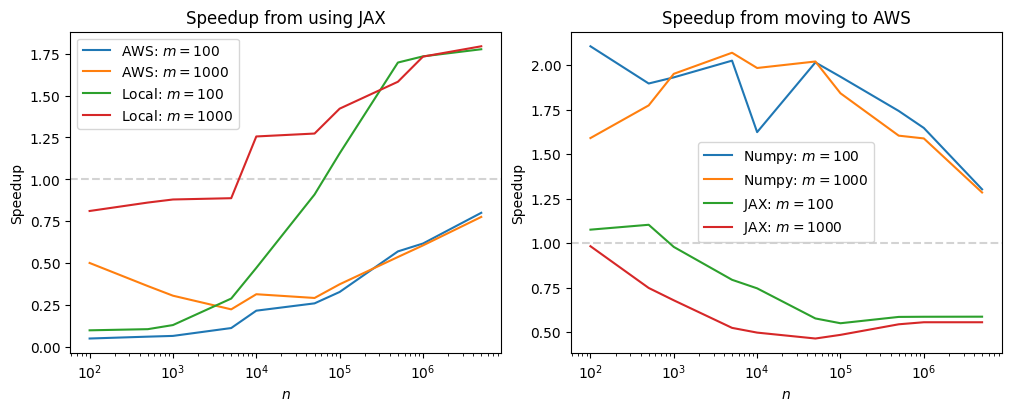

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

axs[0].axhline(1, linestyle='--', color='lightgray');
axs[0].plot(calculate_speedup(thinning_jax_speedup_m_fixed_aws(100)), label='AWS: $m=100$');
axs[0].plot(calculate_speedup(thinning_jax_speedup_m_fixed_aws(1000)), label='AWS: $m=1000$');
axs[0].plot(calculate_speedup(thinning_jax_speedup_m_fixed_local(100)), label='Local: $m=100$');
axs[0].plot(calculate_speedup(thinning_jax_speedup_m_fixed_local(1000)), label='Local: $m=1000$');
axs[0].set_xlabel('$n$');
axs[0].set_ylabel('Speedup');
axs[0].set_title('Speedup from using JAX');
axs[0].set_xticks(ns);
axs[0].set_xscale('log');
axs[0].legend();

axs[1].axhline(1, linestyle='--', color='lightgray');
axs[1].plot(thinning_jax_speedup_m_fixed_local(100)['Numpy'] / thinning_jax_speedup_m_fixed_aws(100)['Numpy'], label='Numpy: $m=100$');
axs[1].plot(thinning_jax_speedup_m_fixed_local(1000)['Numpy'] / thinning_jax_speedup_m_fixed_aws(1000)['Numpy'], label='Numpy: $m=1000$');
axs[1].plot(thinning_jax_speedup_m_fixed_local(100)['JAX'] / thinning_jax_speedup_m_fixed_aws(100)['JAX'], label='JAX: $m=100$');
axs[1].plot(thinning_jax_speedup_m_fixed_local(1000)['JAX'] / thinning_jax_speedup_m_fixed_aws(1000)['JAX'], label='JAX: $m=1000$');
axs[1].set_xlabel('$n$');
axs[1].set_ylabel('Speedup');
axs[1].set_title('Speedup from moving to AWS');
axs[1].set_xticks(ns);
axs[1].set_xscale('log');
axs[1].legend();